In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
import pickle
from tensorflow import keras
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout, RandomFlip, RandomZoom, RandomRotation, Rescaling, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [2]:
# Load CIFAR10 model using 'unpickle' function
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

#open all the batches
batch_files = [f'./cifar-10-batches-py/data_batch_{i}' for i in range(1, 6)]

# open the meta batch
meta_data = unpickle('./cifar-10-batches-py/batches.meta')
label_names = meta_data[b'label_names']
# Decode byte strings to regular strings
label_names = [label.decode('utf-8') for label in label_names]

# Initialize empty lists to store the data and labels
data_list = []
labels_list = []

# Loop over each batch file and load the data
for file in batch_files:
    batch = unpickle(file)
    data_list.append(batch[b'data'])   # Append image data
    labels_list.append(batch[b'labels'])  # Append labels

# Concatenate all data and labels into a single dataset
X_train = np.concatenate(data_list)
y_train = np.concatenate(labels_list)
# load the first batch for smaller training sample
#batch1 = unpickle('./cifar-10-batches-py/data_batch_1')
#X_train = batch1[b'data'][:3000]
#y_train = batch1[b'labels'][:3000]

# Optionally, load the test batch
test_batch = unpickle('./cifar-10-batches-py/test_batch')
X_test = test_batch[b'data']
y_test = np.array(test_batch[b'labels'])

# Reshape the training and test data to 32x32x3 (for images)
X_train = X_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
X_test = X_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)


# Resize the images to 299x299
X_train_resized = np.array([cv2.resize(img, (96, 96)) for img in X_train])
X_test_resized = np.array([cv2.resize(img, (96, 96)) for img in X_test])


# Normalize the images
X_train = X_train_resized.astype('float16') /255
X_test = X_test_resized.astype('float16') /255

# One-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#train_generator = train_datagen.flow(X_train_resized, y_train, batch_size=32)
#test_generator = test_datagen.flow(X_test_resized, y_test, batch_size=32)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)



(50000, 96, 96, 3) (50000, 10) (10000, 96, 96, 3) (10000, 10)


In [3]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Initialize the Sequential model
model = models.Sequential()

# First Convolutional Block
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())   # Batch Normalization to stabilize training
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))   # Downsample the feature maps
model.add(layers.Dropout(0.1))          # Dropout to prevent overfitting

# Second Convolutional Block
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())   # Batch Normalization to stabilize training

model.add(layers.MaxPooling2D((2, 2)))   # Downsample the feature maps
model.add(layers.Dropout(0.2))         # Dropout for further regularization

# Third Convolutional Block
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())   # Batch Normalization to stabilize training

model.add(layers.MaxPooling2D((2, 2)))   # Downsample the feature maps
model.add(layers.Dropout(0.2))         # Dropout for further regularization

# Fourth Convolutional Block
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())   # Batch Normalization to stabilize training

model.add(layers.MaxPooling2D((2, 2)))   # Downsample the feature maps
model.add(layers.Dropout(0.3)) 

# Fifth Convolutional Block
model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())   # Batch Normalization to stabilize training

model.add(layers.MaxPooling2D((2, 2)))   # Downsample the feature maps
model.add(layers.Dropout(0.4)) 


# Flatten the output and add Fully Connected layers (Dense layers)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))  # Dropout to prevent overfitting



# Output Layer
model.add(layers.Dense(10, activation='softmax'))


# Summarize the model architecture
model.summary()

# Define the epochs, batch size and number of classes
num_classes = 10
epochs = 100
batch_size = 64

# Optimizers
Adam = Adam(learning_rate=0.00003)
SGD = SGD(learning_rate=0.00001, momentum=0.9, nesterov=True)

# Other parameters
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Compile the model
model.compile(optimizer= SGD,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_split=0.2,
                    shuffle=True,
                    callbacks= [early_stopping, reduce_lr]
                    )


c:\Users\danis\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 2, 512)      │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 1, 512)      │             

 Total params: 1,011,114 (3.86 MB)

 Trainable params: 1,009,386 (3.85 MB)

 Non-trainable params: 1,728 (6.75 KB)

Epoch 1/100



KeyboardInterrupt



In [65]:
# Load our model from pickle document
with open('./CNN__Charlie_Dani.pkl', 'rb') as f:
    our_model = pickle.load(f)   

In [5]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import Xception




# Load the pre-trained Xception model without the top layers
base_model = Xception(weights="imagenet", include_top=False, input_shape=(96, 96, 3))

# Your custom model architecture for the top layers
def build_custom_top_layers():
    model = models.Sequential()
    
    # First Convolutional Block
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Second Convolutional Block
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Third Convolutional Block
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    # Fourth Convolutional Block
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))

    # Flatten the output and add Fully Connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    
    # Output Layer
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

# Define the epochs, batch size and number of classes
num_classes = 10
epochs = 50
batch_size = 64

# Optimizers
Adam = Adam(learning_rate=0.0003)
SGD = SGD(learning_rate=0.003, momentum=0.9, nesterov=True)

# Other parameters
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)




In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Top layer consists of average pooling and output layer. So we are removing the top layer
base_model = Xception(weights="imagenet", include_top=False, input_shape=(96, 96, 3))
# Freeze the base model layers
for layer in base_model.layers:
  layer.trainable = False



x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(10, activation="softmax")(x)

# Pass the output from Xception to 'our_model'
model_ImagNet = Model(inputs=base_model.input, outputs=output)

# Recompile the model
optimizer_2 = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, nesterov=True)
model_ImagNet.compile(optimizer=optimizer_2, loss='categorical_crossentropy', metrics=['accuracy'])
history = model_ImagNet.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)




Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 390s 306ms/step - accuracy: 0.5940 - loss: 5.8813 - val_accuracy: 0.6732 - val_loss: 6.3842
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 301s 241ms/step - accuracy: 0.6568 - loss: 6.9410 - val_accuracy: 0.6840 - val_loss: 6.5202
Epoch 3/5
 373/1250 ━━━━━━━━━━━━━━━━━━━━ 3:00 206ms/step - accuracy: 0.6730 - loss: 6.9909

AbortedError: Graph execution error:

Detected at node StatefulPartitionedCall/functional_27_1/block10_sepconv3_1/separable_conv2d defined at (most recent call last):
<stack traces unavailable>
Operation received an exception:Status: 1, message: could not create a memory object, in file tensorflow/core/kernels/mkl/mkl_conv_ops.cc:1112
	 [[{{node StatefulPartitionedCall/functional_27_1/block10_sepconv3_1/separable_conv2d}}]] [Op:__inference_one_step_on_iterator_19138]

In [76]:
for layer in base_model.layers[:100]:  # Unfreeze the first 100 layers
    layer.trainable = True

optimizer_3 = keras.optimizers.SGD(learning_rate=0.003, momentum=0.9, nesterov=True)

model_ImagNet.compile(loss="categorical_crossentropy", optimizer=optimizer_3, metrics=["accuracy"])
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath='model_epoch_{epoch:02d}_val_acc_{val_accuracy:.4f}.keras',  # Path to save the model file
    monitor='val_accuracy',          # Metric to monitor (you can also use 'val_accuracy' or other metrics)
    save_best_only=True,             # Save only the best model (based on monitored metric)
    mode='max',                      # Minimize the monitored metric (for 'val_loss', use 'min'; for accuracy, use 'max')
    save_weights_only=False,         # Whether to save the whole model or just the weights
    verbose=0                        # Display info when saving
)

history = model_ImagNet.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2, callbacks=[checkpoint])

from sklearn.metrics import confusion_matrix
gt = np.argmax(y_test, axis=1)
y_pred_transfer = model_ImagNet.predict(X_test)

predictions = np.argmax(y_pred_transfer, axis=1)
confusion_matrix(gt, predictions)

Epoch 1/20
 263/2500 ━━━━━━━━━━━━━━━━━━━━ 16:49 451ms/step - accuracy: 0.1655 - loss: 2.2079

KeyboardInterrupt: 

In [58]:



gt = np.argmax(y_test, axis=1)
y_pred_transfer2 = model_ImagNet.predict(X_test)


predictions = np.argmax(y_pred_transfer2, axis=1)


313/313 ━━━━━━━━━━━━━━━━━━━━ 73s 232ms/step
(2000,)


In [60]:
print(predictions.shape)

(10000,)


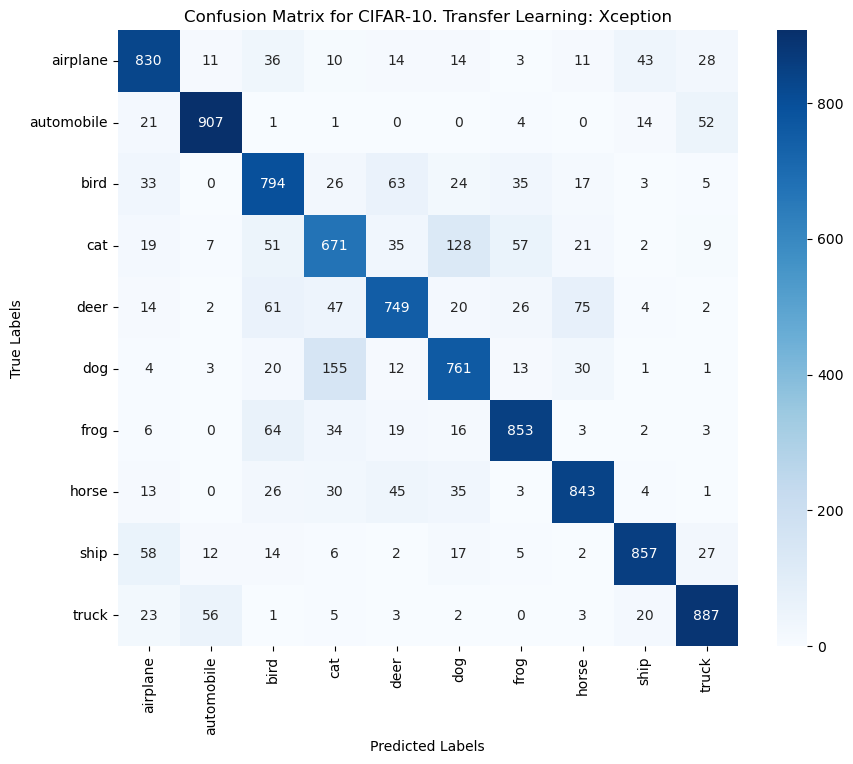

In [59]:


import seaborn as sns
# Compute the confusion matrix
conf_matrix = confusion_matrix(gt, predictions)
# Visualize the confusion matrix to understand model performance across different classes.
""""Rows represent the true labels (the actual class of the images).
Columns represent the predicted labels (the class predicted by your model).
The diagonal values (top-left to bottom-right) represent correctly classified images.
Off-diagonal values represent misclassifications (e.g., if an image from class 2 was classified as class 5)."""
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for CIFAR-10. Transfer Learning: Xception')
plt.show()

In [61]:
# Save Model as pickle file
import pickle
with open('CNN_transfer_learning_Xception_Charlie_Dani.pkl', 'wb') as f:
    pickle.dump(model, f)
    
from keras.backend import clear_session
clear_session()

# Top layer consists of average pooling and output layer. So we are removing the top layer
base_model = Xception(weights="imagenet", include_top=False, input_shape=(96, 96, 3))
# Freeze the base model layers
for layer in base_model.layers:
  layer.trainable = False

#And here we are creating our own average pooling and output layer
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(10, activation="softmax")(avg)

# Build your custom top layers
custom_top_layers = build_custom_top_layers()

# Combine the base model and custom top layers
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer= SGD,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

# Summarize the combined model
model.summary()

# Train the model
history = model.fit(train_generator, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_split=test_generator, 
                    shuffle=True)

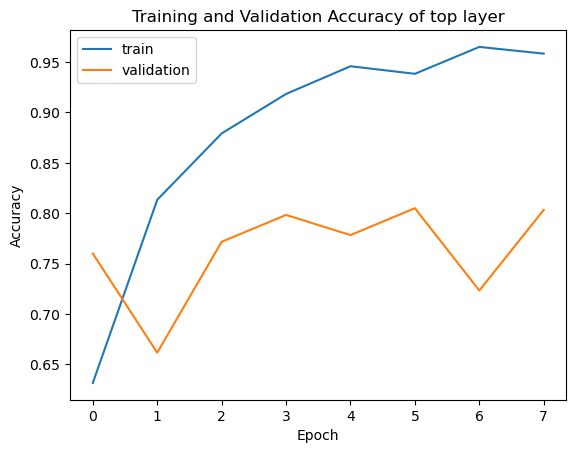

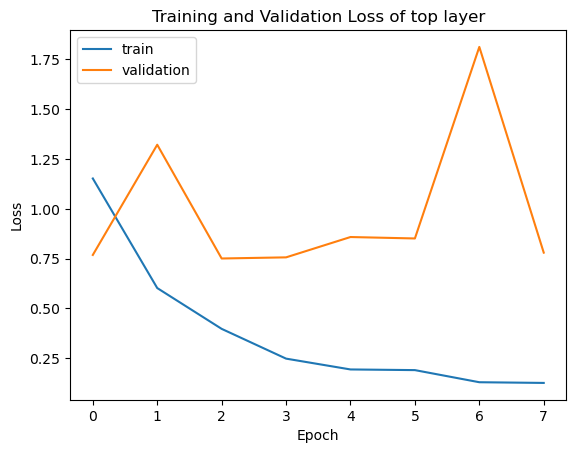

In [85]:
import matplotlib.pyplot as plt

# Get the training and validation accuracy and loss from the history object
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the training and validation accuracy
plt.plot(training_accuracy)
plt.plot(validation_accuracy)
plt.title('Training and Validation Accuracy of top layer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(training_loss)
plt.plot(validation_loss)
plt.title('Training and Validation Loss of top layer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()